## TEST TWO:  multiclass classifier on binned labeling, clustered features

11 bins lead to 11 labels

tree classifier used on binned labels (variant)

imbalanced classes in data

## classifier method search

premise: use a looped grid search to explore the accuracy metrics of classfiers

In [2]:
!pip3 install shap
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [67]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.metrics import accuracy_score, make_scorer
import numpy as np 


In [11]:
m2_pipeline = pd.read_csv('binary_clustered_resampled_pipeline.csv')


## testing data for colinearity among features

In [12]:
m2_pipeline.corr(numeric_only=True)

,Unnamed: 0,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,time,Cluster_Label,label
Unnamed: 0,1.000000,0.045079,0.085768,0.061816,-0.013264,-0.263562,-0.067443,0.182522,0.063883,0.847406
precursor_buy_cap_pct_change,0.045079,1.000000,0.177412,0.819999,0.235252,-0.052100,-0.089824,-0.203573,0.187654,0.069733
precursor_ask_cap_pct_change,0.085768,0.177412,1.000000,0.389269,0.186800,-0.370681,-0.007078,-0.125665,0.921584,0.098718
precursor_bid_vol_pct_change,0.061816,0.819999,0.389269,1.000000,0.226193,-0.187266,-0.013888,-0.234427,0.352453,0.085298
precursor_ask_vol_pct_change,-0.013264,0.235252,0.186800,0.226193,1.000000,0.010846,-0.017990,-0.052507,0.188756,-0.013578
sum_change,-0.263562,-0.052100,-0.370681,-0.187266,0.010846,1.000000,-0.110174,0.205732,-0.350047,-0.316919
length,-0.067443,-0.089824,-0.007078,-0.013888,-0.017990,-0.110174,1.000000,0.152965,-0.007389,-0.102691
time,0.182522,-0.203573,-0.125665,-0.234427,-0.052507,0.205732,0.152965,1.000000,-0.102263,-0.106554
Cluster_Label,0.063883,0.187654,0.921584,0.352453,0.188756,-0.350047,-0.007389,-0.102263,1.000000,0.073154
label,0.847406,0.069733,0.098718,0.085298,-0.013578,-0.316919,-0.102691,-0.106554,0.073154,1.000000


<Axes: >

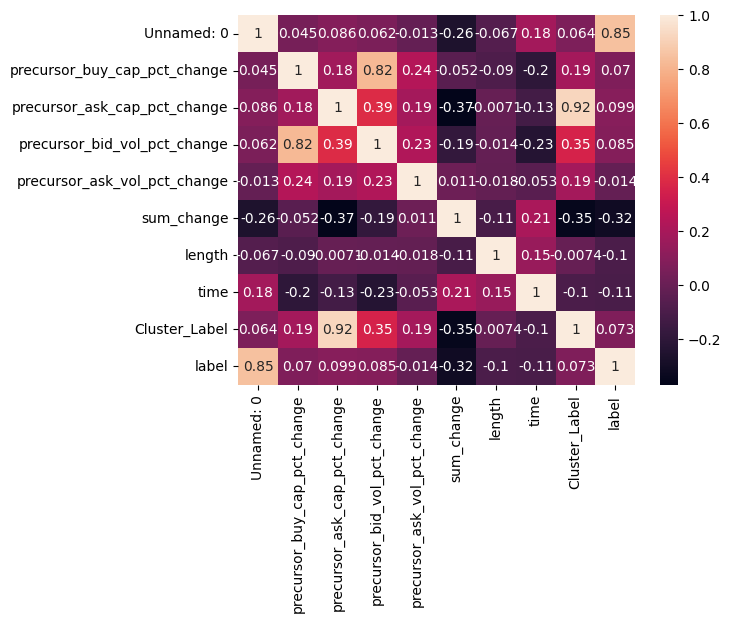

In [13]:
import pandas as pd
import seaborn as sns

# Load the dataset into a pandas dataframe

# Calculate the correlation matrix
corr_matrix = m2_pipeline.corr(numeric_only=True)

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True)


XGB, GBM, CAT, FASTAI, NN_TORCH, LR, RF, XT

In [14]:
m2_pipeline.dtypes

Unnamed: 0                        int64
precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                            int64
time                            float64
Cluster_Label                     int64
label                             int64
dtype: object

### utilize the same feature composition as used in step 2

clustering setup, per 'step 2'

set m2_pipeline features to the set, below to do a classifier search

In [15]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time','Cluster_Label']

### classifier search

use Cross Validated Grid Search to identify an optimally accurate/F1 classifer.

In [16]:

# Splitting the dataframe into features and labels
y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Define the classifiers and their respective hyperparameters
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    RidgeCV(),
    LassoCV(),
    SVC()
]

params = {
    'RandomForestClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'GradientBoostingClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_iter': [100, 200]},
    'ExtraTreesClassifier':{'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'BaggingClassifier':{ 'n_estimators':[10],  'random_state':[42]},
    'RidgeCV':{'alphas':[0.1, 1.0, 10.0]},
    'LassoCV':{ 'eps':[0.001, 0.01, .1], 'n_alphas':[100,200],  'max_iter':[100,200,300,1000]},
    'SVC':{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}
comparative = []
cv_result_df = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=4)
        grid_search.fit(X_train_scaled, y_train)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test_scaled, y_test)
        
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
        cv_result_df.append(grid_search.cv_results_)

dg = pd.DataFrame(comparative) #display grid

Best parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 1000}
Best parameters for GradientBoostingClassifier: {'max_depth': 10, 'n_estimators': 1000}
Best parameters for HistGradientBoostingClassifier: {'learning_rate': 0.1, 'max_iter': 200}
Best parameters for ExtraTreesClassifier: {'max_depth': 100, 'n_estimators': 1000}
Best parameters for BaggingClassifier: {'n_estimators': 10, 'random_state': 42}
Best parameters for RidgeCV: {'alphas': 10.0}
Best parameters for LassoCV: {'eps': 0.001, 'max_iter': 100, 'n_alphas': 100}
Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}


In [17]:
dg

,classifier,best_params,accuracy
0,RandomForestClassifier,"{'max_depth': None, 'n_estimators': 1000}",0.779624
1,GradientBoostingClassifier,"{'max_depth': 10, 'n_estimators': 1000}",0.775251
2,HistGradientBoostingClassifier,"{'learning_rate': 0.1, 'max_iter': 200}",0.813730
3,ExtraTreesClassifier,"{'max_depth': 100, 'n_estimators': 1000}",0.864014
4,BaggingClassifier,"{'n_estimators': 10, 'random_state': 42}",0.755575
5,RidgeCV,{'alphas': 10.0},0.106149
6,LassoCV,"{'eps': 0.001, 'max_iter': 100, 'n_alphas': 100}",0.106628
7,SVC,"{'C': 10, 'kernel': 'rbf'}",0.847398


In [18]:
sensitivity_analysis = pd.DataFrame(cv_result_df)
# sensitivity_analysis

In [19]:
rfc = RandomForestClassifier(max_depth=100, n_estimators=100,random_state= 42)
gbc = GradientBoostingClassifier(max_depth= 10, n_estimators= 1000,random_state= 42)
hgbc = HistGradientBoostingClassifier(learning_rate= 0.1, max_iter= 200,random_state= 42)
etc = ExtraTreesClassifier(max_depth= 100, n_estimators= 1000,random_state= 42)
bc = BaggingClassifier(n_estimators= 10, random_state= 42)
svc = SVC(C=1, kernel='rbf')
treeGroup = [rfc, etc, gbc, hgbc] #tree based classifiers, for feature importance

## Voting Classifier

In [20]:
import shap #this library would take 30 hours to explain the above model, not to be used. would function on one tree, better
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score
X = m2_pipeline[keepable].values  #.drop(columns=['label']).values #per https://stackoverflow.com/a/73095562/12001832
y = m2_pipeline['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Define VotingClassifier 
# weights = [0.1, 0.5, 0.1, 0.1, 0.2]
vc = VotingClassifier(estimators=[('rfc',rfc),('gbc',gbc),('hgbc',hgbc),('etc',etc),('bc',bc)], voting='soft')  #, weights=weights) 
rfc.fit(X_train_scaled,y_train)
gbc.fit(X_train_scaled,y_train)
hgbc.fit(X_train_scaled,y_train)
etc.fit(X_train_scaled,y_train)
bc.fit(X_train_scaled,y_train)
svc.fit(X_train_scaled,y_train)
vc.fit(X_train_scaled,y_train)

# #fit all, voting classifier scoring
for clf, label in zip([rfc,gbc,hgbc,etc,bc,svc,vc], ['RandomForestClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'ExtraTreesClassifier',\
                                                    'BaggingClassifier','SVC','Voting']):
    scores = cross_val_score(clf, X_test_scaled, y_test, scoring='accuracy', cv=4)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.91 (+/- 0.01) [RandomForestClassifier]
Accuracy: 0.93 (+/- 0.00) [GradientBoostingClassifier]
Accuracy: 0.94 (+/- 0.00) [HistGradientBoostingClassifier]
Accuracy: 0.93 (+/- 0.00) [ExtraTreesClassifier]
Accuracy: 0.89 (+/- 0.01) [BaggingClassifier]
Accuracy: 0.77 (+/- 0.02) [SVC]
Accuracy: 0.93 (+/- 0.00) [Voting]


### feature importance based on feature permutation
[via scikit learn's rendition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-feature-permutation)

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length', 'time',
       'Cluster_Label', 'label'],
      dtype='object') 8
RandomForestClassifier(max_depth=100, random_state=42)


Elapsed time to compute the importances: 2.044 seconds
RandomForestClassifier(max_depth=100, random_state=42)


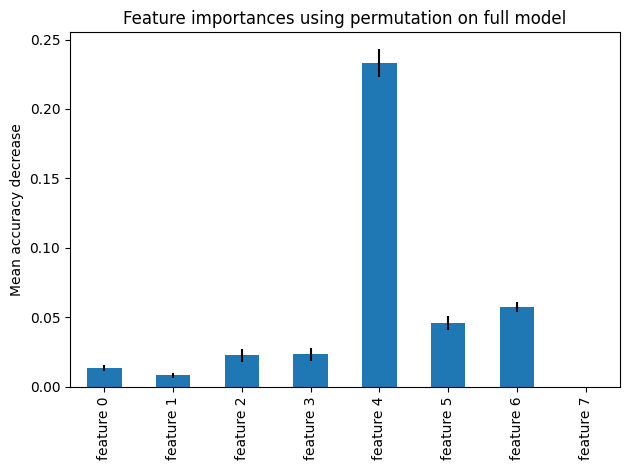

ExtraTreesClassifier(max_depth=100, n_estimators=1000, random_state=42)
Elapsed time to compute the importances: 16.675 seconds
ExtraTreesClassifier(max_depth=100, n_estimators=1000, random_state=42)


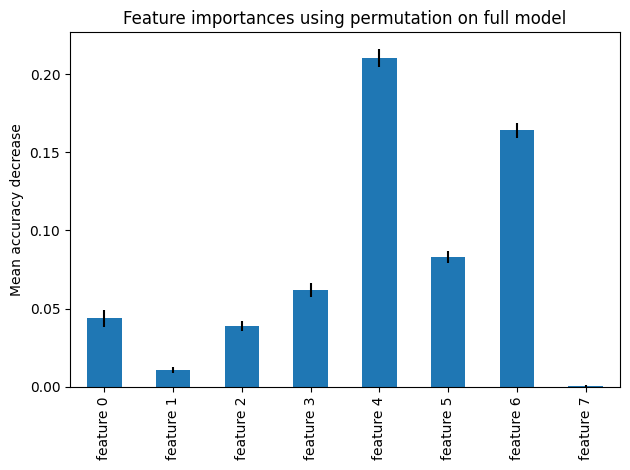

GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42)
Elapsed time to compute the importances: 3.438 seconds
GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42)


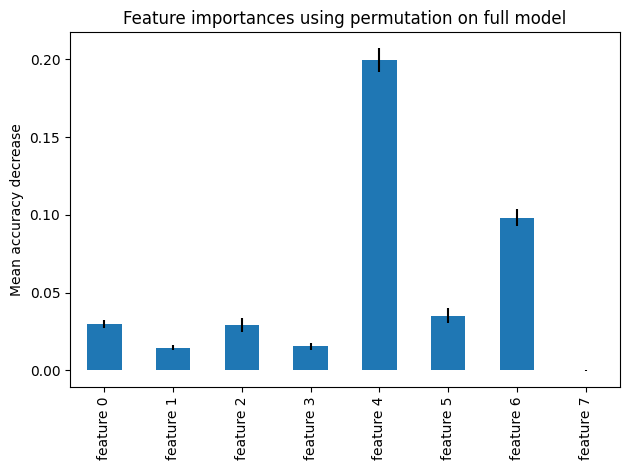

HistGradientBoostingClassifier(max_iter=200, random_state=42)
Elapsed time to compute the importances: 1.013 seconds
HistGradientBoostingClassifier(max_iter=200, random_state=42)


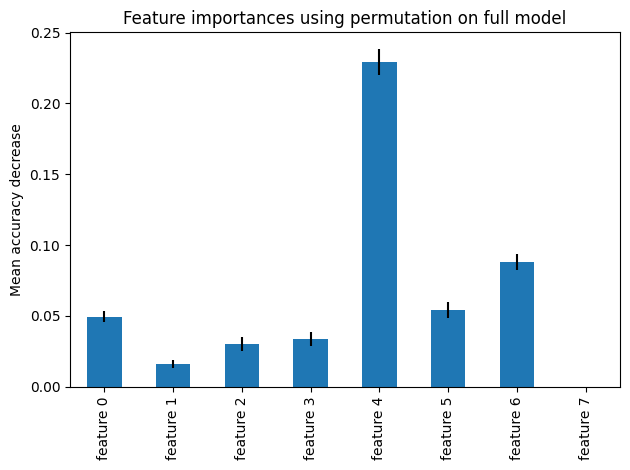

In [61]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

print(m2_pipeline.columns,X.shape[1])
for i in range(len(treeGroup)):
    print(treeGroup[i]) #tree to study
    forest = treeGroup[i]
    start_time = time.time()
    result = permutation_importance(forest, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=2)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    print(treeGroup[i]) #tree to study

    plt.show()

## most critical feature: 

precursor_ask_vol_pct_change

precursor_ask_cap_pct most correlated to cluster label

## Error Analysis

confusion matrix for multiclass predict vs true results. [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html)

In [22]:
labels_ = m2_pipeline['label'].unique()
print(labels_)

[0 1]


## voting classifier error analysis

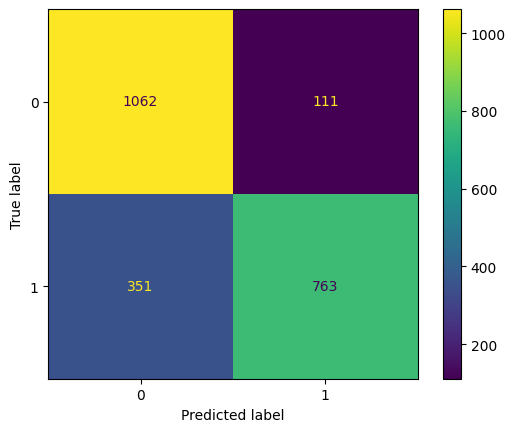

In [23]:
# X_test_scaled = scaler.fit_transform(X_test)
y_pred = vc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels_)

error report courtesty of sklearn's [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report)

In [24]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1173
           1       0.87      0.68      0.77      1114

    accuracy                           0.80      2287
   macro avg       0.81      0.80      0.79      2287
weighted avg       0.81      0.80      0.80      2287



uncertainty in prediction, per class basis, [per sklearn](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#plot-the-most-uncertain-predictions)

## SHAP feature analysis

[source](https://github.com/shap/shap)

In [25]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length','time','Cluster_Label']

### Random Forest Classifier Feature Strength

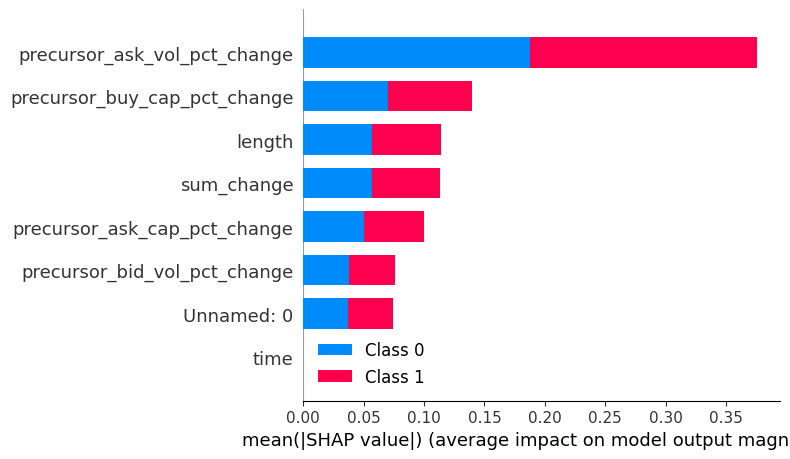

In [26]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = rfc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### HGBC SHAP

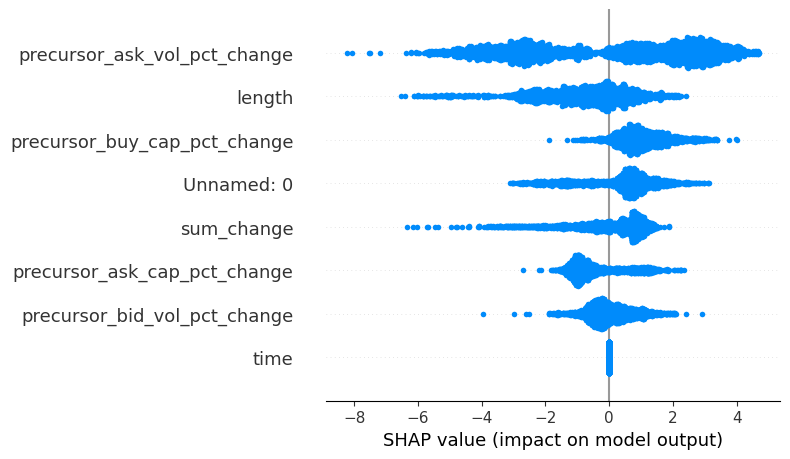

In [27]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = hgbc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### Extra Trees Classifier SHAP

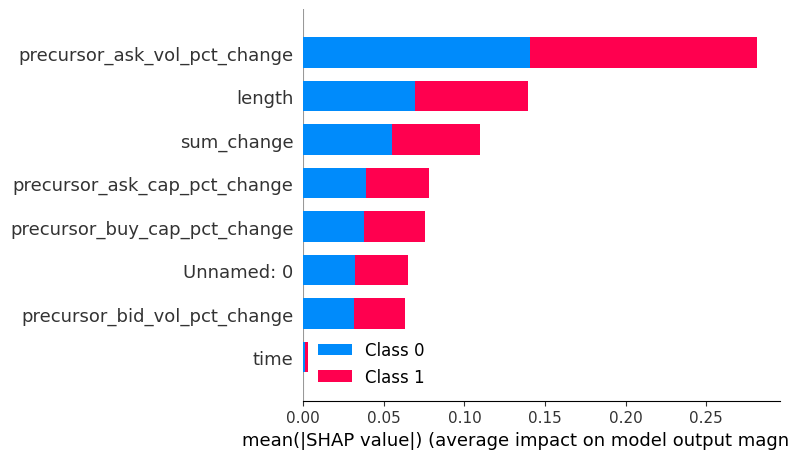

In [28]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = etc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## 


### How do multiple classifiers collectively make good choices?

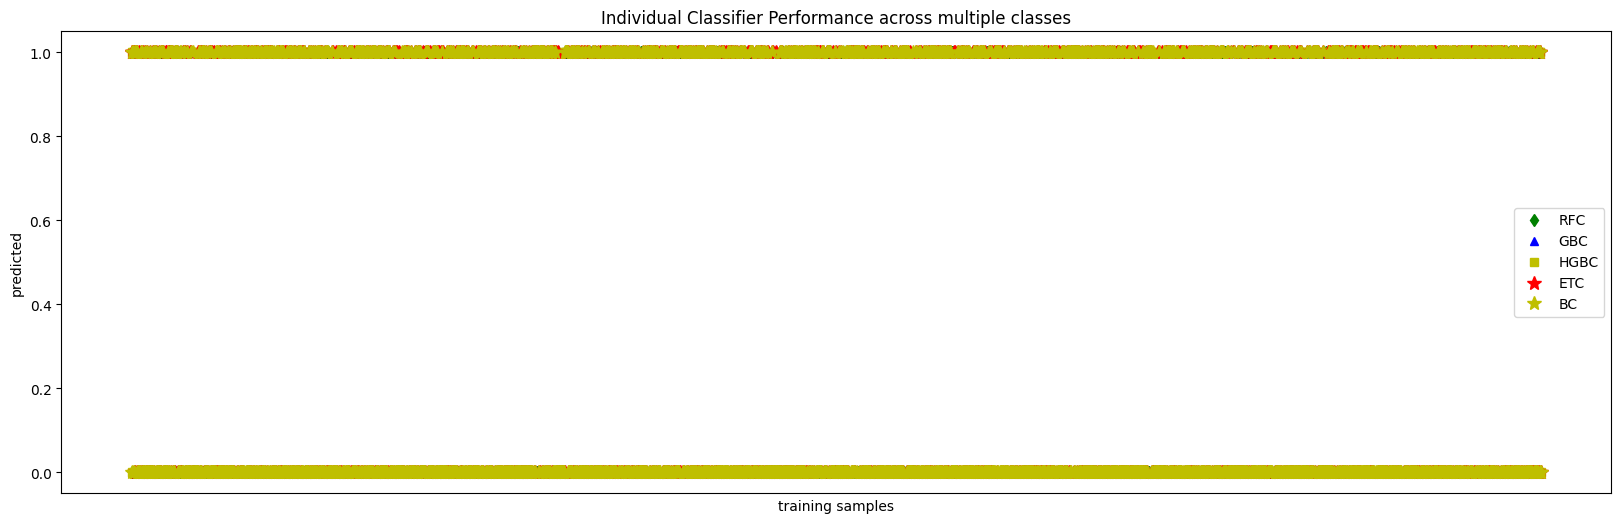

In [29]:
xt = X_test_scaled#  train_scaled[:300]

pred1 = rfc.predict(xt)
pred2 = gbc.predict(xt)
pred3 = hgbc.predict(xt)

pred4 = etc.predict(xt)
pred5 = bc.predict(xt)
pred6 = vc.predict(xt)

plt.figure(figsize=(20,6))
plt.plot(pred1, "gd", label="RFC")
plt.plot(pred2, "b^", label="GBC")
plt.plot(pred3, "ys", label="HGBC")
plt.plot(pred4, "r*", ms=10, label="ETC")
plt.plot(pred5, "y*", ms=10, label="BC")
# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
# ax.annotate('race interrupted', (61, 25),
#             xytext=(0.8, 0.9), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='top')
plt.show()


### Can the voting classifier locate optimal trades among a sea of lesser options?

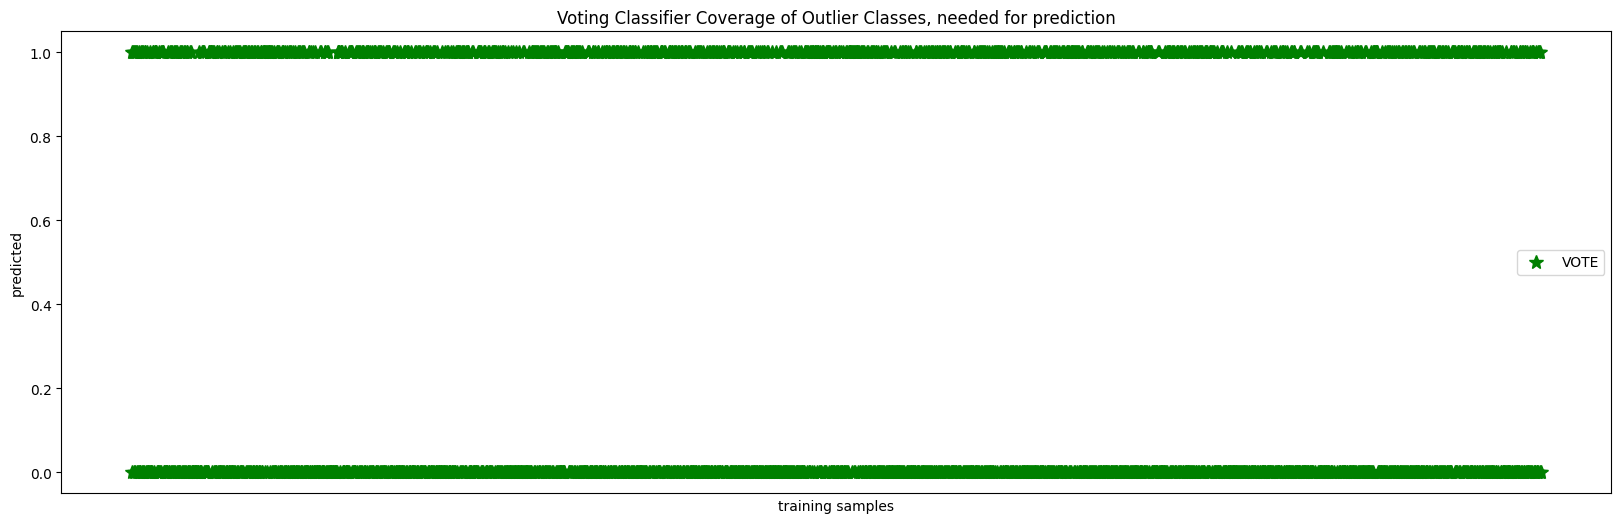

In [30]:
plt.figure(figsize=(20,6))
plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Voting Classifier Coverage of Outlier Classes, needed for prediction")
plt.show()

### BC ability to identify outlier, profitable classes

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      1173
           1       0.83      0.62      0.71      1114

    accuracy                           0.76      2287
   macro avg       0.77      0.75      0.75      2287
weighted avg       0.77      0.76      0.75      2287



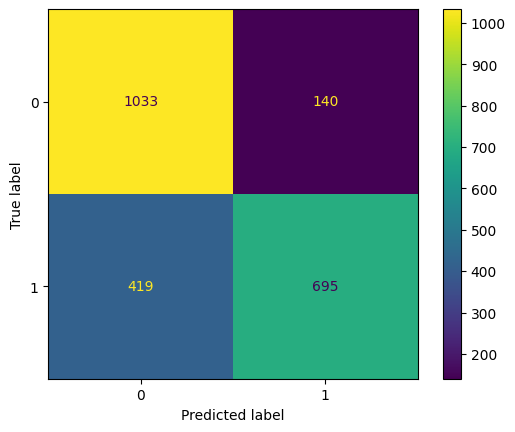

In [31]:
# X_test_scaled = scaler.fit_transform(X_test)
y_pred_gbc = bc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gbc, labels=labels_)

print(classification_report(y_test, y_pred_gbc,zero_division=1))


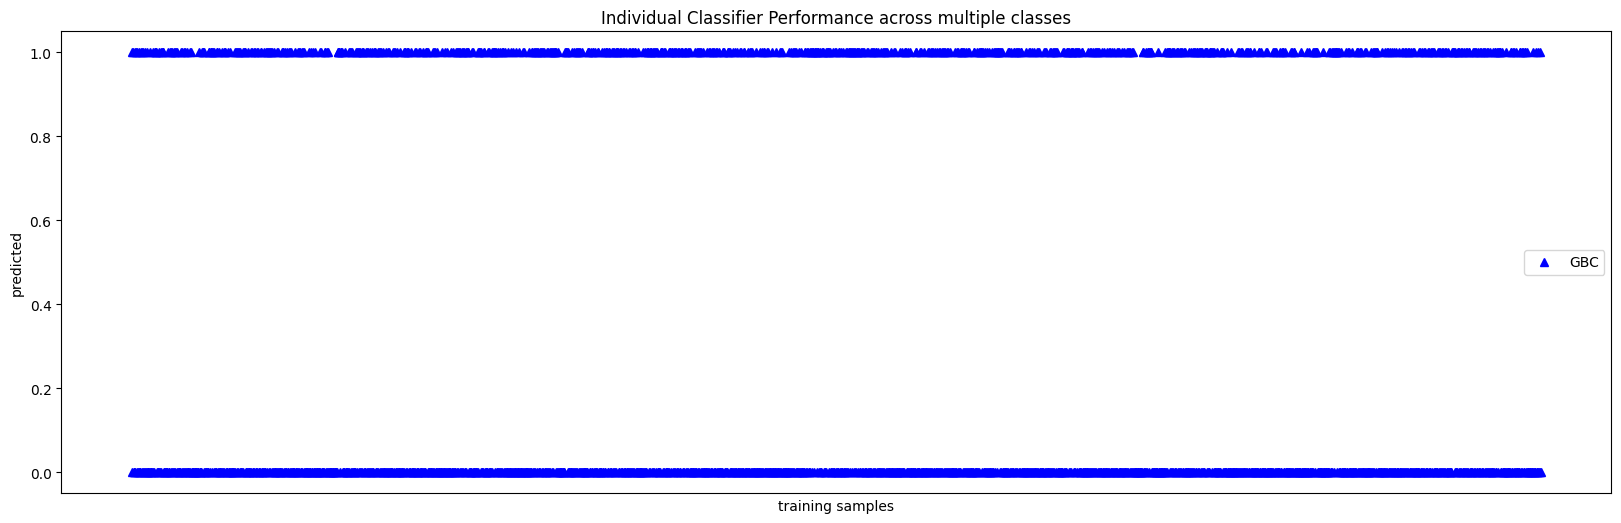

In [32]:
plt.figure(figsize=(20,6))
plt.plot(pred2, "b^", label="GBC")

# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
plt.show()


## Sensitivity Analysis from parameter search
bearing of major parameters on accuracy outcomes
resources [1](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#demonstration-of-multi-metric-evaluation-on-cross-val-score-and-gridsearchcv)

In [51]:
#get best predicted features from all bundled classifiers in teh vc:
sub_estimators = vc.estimators_
print(sub_estimators)
print(sub_estimators[0], sub_estimators[0].feature_importances_)
print(sub_estimators[1], sub_estimators[1].feature_importances_)
print(sub_estimators[3], sub_estimators[3].feature_importances_)

[RandomForestClassifier(max_depth=100, random_state=42), GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42), HistGradientBoostingClassifier(max_iter=200, random_state=42), ExtraTreesClassifier(max_depth=100, n_estimators=1000, random_state=42), BaggingClassifier(random_state=42)]
RandomForestClassifier(max_depth=100, random_state=42) [1.19400098e-01 1.17380191e-01 1.42790157e-01 1.13570769e-01
 2.68177822e-01 7.84471824e-02 1.60119214e-01 1.14566514e-04]
GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42) [1.22012207e-01 8.71292404e-02 5.40827183e-02 7.10774620e-02
 3.40916869e-01 9.54109548e-02 2.29262695e-01 1.07852718e-04]
ExtraTreesClassifier(max_depth=100, n_estimators=1000, random_state=42) [0.12567344 0.10253326 0.11353001 0.11388094 0.26764098 0.08276526
 0.19215963 0.00181649]


In [60]:
param_vars = ['param_max_depth', 'param_n_estimators','param_learning_rate', 'param_max_iter', 'param_random_state','param_alphas', 'param_eps', 'param_n_alphas', 'param_C','param_kernel']

### sensitivity analysis for highest performing classifier

look at the top accurate classifier for the voting classifier, describe how its parameters create variant accuracy

iterate this list and visualize for amajor params?

In [114]:
import numpy as np

hgbc = HistGradientBoostingClassifier(learning_rate= 0.1, max_iter= 200,random_state= 42)

classifiers = [
    'RandomForestClassifier',
    'GradientBoostingClassifier',
    'HistGradientBoostingClassifier',
    'ExtraTreesClassifier',
    'BaggingClassifier',
    'RidgeCV',
    'LassoCV',
    'SVC']

params = {
    'RandomForestClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'GradientBoostingClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_iter': [100, 200]},
    'ExtraTreesClassifier':{'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'BaggingClassifier':{ 'n_estimators':[10],  'random_state':[42]},
    'RidgeCV':{'alphas':[0.1, 1.0, 10.0]},
    'LassoCV':{ 'eps':[0.001, 0.01, .1], 'n_alphas':[100,200],  'max_iter':[100,200,300,1000]},
    'SVC':{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}



## HGBC

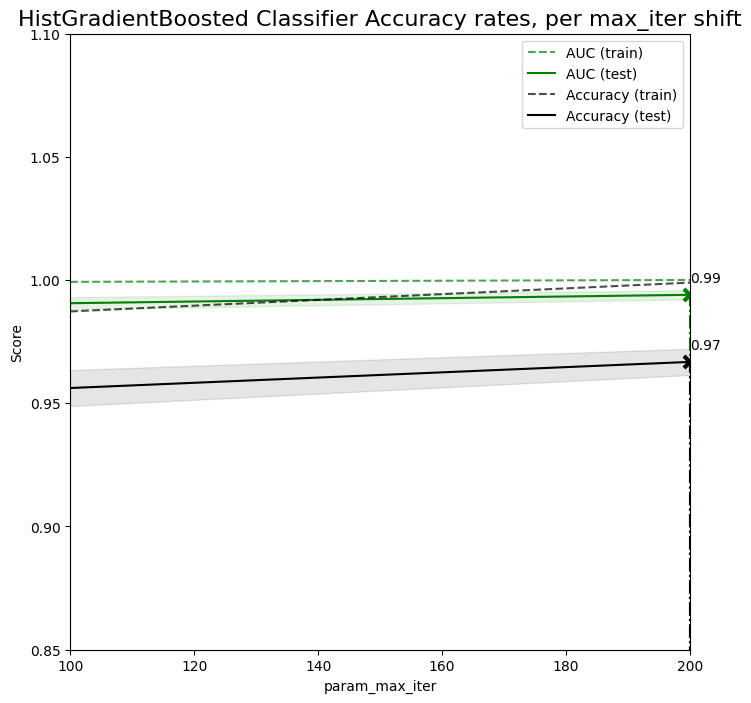

In [118]:
r =sensitivity_analysis.iloc[2]
r['params']
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(
    HistGradientBoostingClassifier(),
    param_grid={  "max_iter":(100,200)},  #"learning_rate":(0.1, 0.01),
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X_train_scaled, y_train)
results = gs.cv_results_
plt.figure(figsize=(8, 8))
plt.title("HistGradientBoosted Classifier Accuracy rates, per max_iter shift", fontsize=16)

plt.xlabel("param_max_iter")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(100, 200)
ax.set_ylim(0.85, 1.1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_max_iter"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

## RFC sensitivity

In [116]:
r =sensitivity_analysis.iloc[0]
r['params']

[{'max_depth': None, 'n_estimators': 10},
 {'max_depth': None, 'n_estimators': 100},
 {'max_depth': None, 'n_estimators': 1000},
 {'max_depth': 10, 'n_estimators': 10},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 1000},
 {'max_depth': 100, 'n_estimators': 10},
 {'max_depth': 100, 'n_estimators': 100},
 {'max_depth': 100, 'n_estimators': 1000}]

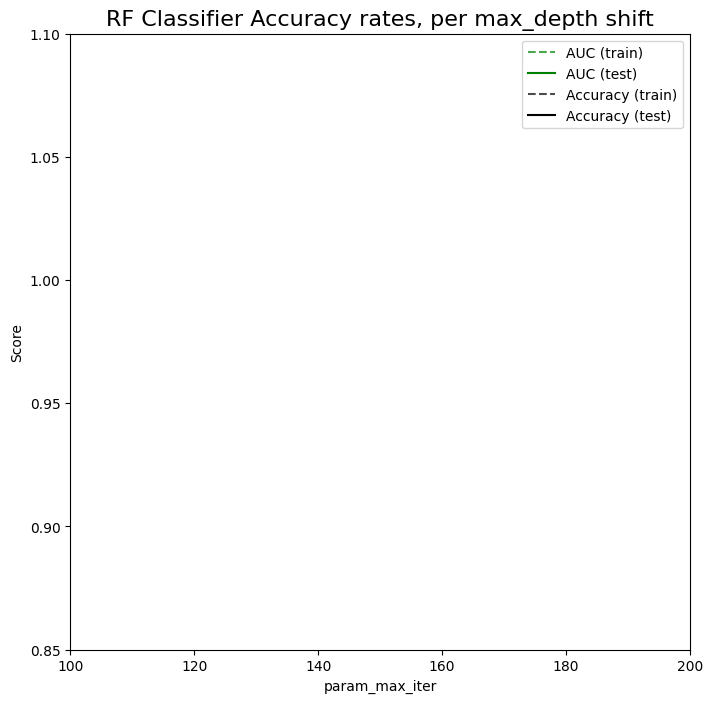

In [120]:

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
gs = GridSearchCV(
    HistGradientBoostingClassifier(),
    param_grid={ "max_depth":range(10,100)},  # "learning_rate":(0.1, 0.01),
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X_train_scaled, y_train)
results = gs.cv_results_
plt.figure(figsize=(8, 8))
plt.title("RF Classifier Accuracy rates, per max_depth shift", fontsize=16)

plt.xlabel("param_max_iter")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(100, 200)
ax.set_ylim(0.85, 1.1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_max_depth"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [90]:
sensitivity_analysis.iloc[0]  #'max_depth': 100, 'n_estimators': 1000}

mean_fit_time          [0.06773078441619873, 0.687698245048523, 6.769...
std_fit_time           [0.001462540335309072, 0.0026468276085208934, ...
mean_score_time        [0.002734243869781494, 0.02210444211959839, 0....
std_score_time         [9.457968796585894e-05, 0.0004060033677963748,...
param_max_depth            [None, None, None, 10, 10, 10, 100, 100, 100]
param_n_estimators         [10, 100, 1000, 10, 100, 1000, 10, 100, 1000]
params                 [{'max_depth': None, 'n_estimators': 10}, {'ma...
split0_test_score      [0.9414079580236118, 0.9505902929602099, 0.953...
split1_test_score      [0.9444444444444444, 0.9593175853018373, 0.958...
split2_test_score      [0.9536307961504812, 0.963254593175853, 0.9632...
split3_test_score      [0.9431321084864392, 0.9457567804024497, 0.949...
mean_test_score        [0.9456538267762441, 0.9547298129600874, 0.956...
std_test_score         [0.004729722788380456, 0.006916835835420822, 0...
rank_test_score                              [5, 3,

## general accuracy shifts, variance per myperparameter shift
how much average scoring changed per hyperparameter shift

In [ ]:
#per split test, get standard deviation or % variance per test

In [102]:
p  = ['params']  #'mean_test_score']  #,'param_max_depth']

sensitivity_analysis  #.iloc[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,param_learning_rate,param_max_iter,param_random_state,param_alphas,param_eps,param_n_alphas,param_C,param_kernel
0,"[0.06773078441619873, 0.687698245048523, 6.769...","[0.001462540335309072, 0.0026468276085208934, ...","[0.002734243869781494, 0.02210444211959839, 0....","[9.457968796585894e-05, 0.0004060033677963748,...","[None, None, None, 10, 10, 10, 100, 100, 100]","[10, 100, 1000, 10, 100, 1000, 10, 100, 1000]","[{'max_depth': None, 'n_estimators': 10}, {'ma...","[0.9414079580236118, 0.9505902929602099, 0.953...","[0.9444444444444444, 0.9593175853018373, 0.958...","[0.9536307961504812, 0.963254593175853, 0.9632...",...,"[0.004729722788380456, 0.006916835835420822, 0...","[5, 3, 1, 9, 7, 8, 6, 4, 2]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[0.409104585647583, 3.916950821876526, 7.45504...","[0.008466078497596143, 0.06606027490070358, 0....","[0.002192676067352295, 0.00992441177368164, 0....","[0.0006517243353305189, 0.0003537781057306894,...","[None, None, None, 10, 10, 10, 100, 100, 100]","[10, 100, 1000, 10, 100, 1000, 10, 100, 1000]","[{'max_depth': None, 'n_estimators': 10}, {'ma...","[0.9191080017490162, 0.9177962396152164, 0.922...","[0.9186351706036745, 0.9216972878390202, 0.923...","[0.9138232720909887, 0.9177602799650044, 0.920...",...,"[0.002299088956312606, 0.0022001263356489385, ...","[8, 6, 4, 3, 2, 1, 9, 7, 5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[0.8960657119750977, 1.805464267730713, 0.8828...","[0.030730333359813417, 0.07530587560171746, 0....","[0.008831202983856201, 0.01593726873397827, 0....","[0.0006645267368134064, 0.00043265012184353653...",NaN,NaN,"[{'learning_rate': 0.1, 'max_iter': 100}, {'le...","[0.94971578487101, 0.965019676432007, 0.873196...","[0.9584426946631671, 0.9623797025371829, 0.881...","[0.9623797025371829, 0.9658792650918635, 0.891...",...,"[0.005145421466051245, 0.005215334396874687, 0...","[2, 1, 4, 3]","[0.1, 0.1, 0.01, 0.01]","[100, 200, 100, 200]",NaN,NaN,NaN,NaN,NaN,NaN
3,"[0.030699551105499268, 0.2775847911834717, 2.8...","[0.0009856848832897266, 0.001967601849814884, ...","[0.0036037564277648926, 0.030333101749420166, ...","[7.207350170011941e-05, 0.0003723242339828525,...","[None, None, None, 10, 10, 10, 100, 100, 100]","[10, 100, 1000, 10, 100, 1000, 10, 100, 1000]","[{'max_depth': None, 'n_estimators': 10}, {'ma...","[0.960209881941408, 0.9645824223874071, 0.9637...","[0.9671916010498688, 0.9728783902012248, 0.972...","[0.9702537182852143, 0.9720034995625547, 0.972...",...,"[0.00675057467140381, 0.007716156453671543, 0....","[5, 4, 2, 9, 7, 8, 6, 3, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[0.21678918600082397],[0.008613278731393411],[0.0028768181800842285],[2.943642834220489e-05],NaN,[10],"[{'n_estimators': 10, 'random_state': 42}]",[0.9309138609532138],[0.9457567804024497],[0.9540682414698163],...,[0.00830301197658191],[1],NaN,NaN,[42],NaN,NaN,NaN,NaN,NaN
5,"[0.15774232149124146, 0.26209592819213867, 0.1...","[0.03043445669743529, 0.05079464829281245, 0.0...","[0.049146056175231934, 0.03938502073287964, 0....","[0.01767738482563768, 0.018112067301020204, 0....",NaN,NaN,"[{'alphas': 0.1}, {'alphas': 1.0}, {'alphas': ...","[0.12978033895755947, 0.12977934408437242, 0.1...","[0.12633832667987288, 0.12634369303196447, 0.1...","[0.13289458587540404, 0.13289669238602786, 0.1...",...,"[0.0030718670909338276, 0.0030719579978514375,...","[3, 2, 1]",NaN,NaN,NaN,"[0.1, 1.0, 10.0]",NaN,NaN,NaN,NaN
6,"[0.20161378383636475, 0.25076645612716675, 0.2...","[0.032756317431673725, 0.014334439869841882, 0...","[0.0571555495262146, 0.04953426122665405, 0.03...","[0.022122308216281212, 0.008188416540309915, 0...",NaN,NaN,"[{'eps': 0.001, 'max_iter': 100, 'n_alphas': 1...","[0.12967684265607748, 0.12967208116242068, 0.1...","[0.12648383386525242, 0.12648347545525396, 0.1...","[0.13288332160980254, 0.1328814814467857,

## create a time series from predicted values

In [ ]:



# Predict labels for your test data
y_pred = gbc.predict(X_test)

X_test_df = pd.DataFrame(X_test)

# Concatenate the predicted labels with X_test_df
result = pd.concat([X_test_df, pd.Series(y_pred, name='predicted_label')], axis=1)

In [ ]:
result['predicted_label'].value_counts()

predicted_label
4    1036
6      62
5      47
7       1
Name: count, dtype: int64

In [ ]:
print('\n'.join([f'{i}: {value}' for i, value in enumerate(keepable)]))

0: precursor_buy_cap_pct_change
1: precursor_ask_cap_pct_change
2: precursor_bid_vol_pct_change
3: precursor_ask_vol_pct_change
4: sum_change
5: length
6: time


In [ ]:
result.dtypes

0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
5                  float64
6                  float64
predicted_label      int64
dtype: object

In [ ]:
# sns.pairplot(result, hue='predicted_label', height=1.5)
result = result.sort_values(by=6)

In [ ]:
keepable = ['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
            'sum_change', 'length', 'time','predicted_label']

result = result.rename(columns={i: keepable[i] for i in range(7)})

In [ ]:
result

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,time,predicted_label
249,-0.015299,0.000020,-0.004036,0.006264,-0.008603,2.0,1.660233e+12,4
994,0.228115,0.002059,0.068068,0.361857,-0.001833,1.0,1.660248e+12,4
202,0.037177,0.000002,0.012805,-0.000020,-0.002608,1.0,1.660269e+12,4
810,0.002496,0.000003,0.002415,0.002366,-0.005046,2.0,1.660284e+12,4
178,0.010109,0.000063,0.003477,0.010538,0.001395,3.0,1.660311e+12,4
...,...,...,...,...,...,...,...,...
343,-0.007012,-0.000032,-0.001792,0.002291,-0.004772,9.0,1.693019e+12,4
706,0.000664,0.001762,0.000027,0.009067,-0.002190,4.0,1.693034e+12,4
23,-0.005735,-0.004602,-0.001633,-0.021460,-0.001690,6.0,1.693046e+12,4
1137,-0.604637,-0.990184,0.384741,-0.122234,-0.302085,5.0,1.693073e+12,4


In [ ]:
gds = pd.read_csv('global_data.csv')

In [ ]:
# make a dataframe by joining gds on result, by time

# chart mp to time as a line  


# chart vertical lines for time and predicted_label


In [ ]:
#save this thing to .pkl format

# import pickle

# with open("model.pkl", "wb") as f:
#     pickle.dump(vc, f)